<a href="https://colab.research.google.com/github/farhansyed13/internshipproject/blob/main/Riceleafcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading data and importing libraries

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import zipfile
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Setting random seed
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/riceleaf'
image_size = (224, 224)

## Basic checks and preprocessing

In [ ]:
# loading and preprocessing the images
def load_and_preprocess_data(data_dir, img_size=(224, 224)):
    """
    Load images from the directory, preprocess them, and create labels.

    Args:
        data_dir: Directory containing class folders with images
        img_size: Target size for images

    Returns:
        x: List of preprocessed images
        y: List of labels
        class_names: List of class names
    """
    x = []
    y = []
    class_names = []

    # Get class folders (assuming each folder is a class)
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    # Ensure we have class directories
    if not class_dirs:
        print(f"Error: No class directories found in {data_dir}.")
        return [], [], []

    print(f"Found class directories: {class_dirs}")

    # Process each class folder
    for idx, class_name in enumerate(sorted(class_dirs)):
        class_path = os.path.join(data_dir, class_name)
        class_names.append(class_name)

        # Get all image files in the class folder (jpg, jpeg, png)
        image_files = [f for f in os.listdir(class_path)
                      if os.path.isfile(os.path.join(class_path, f)) and
                      f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Found {len(image_files)} images in class {class_name}")

        # Process each image
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                # Load image and check validity
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue

                # Convert image to RGB, resize and normalize
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img / 255.0  # scaling

                # Append image and label
                x.append(img)
                y.append(idx)  # Label is the index of the class

            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    # Convert to numpy arrays
    x = np.array(x)
    y = np.array(y)

    print(f"Loaded {len(x)} images with shape {x.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Class names: {class_names}")

    return x, y, class_names



In [ ]:
 x, y, class_names = load_and_preprocess_data((data_dir),img_size=(224, 224))

Found class directories: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Found 40 images in class Bacterial leaf blight
Found 40 images in class Brown spot
Found 39 images in class Leaf smut
Loaded 119 images with shape (119, 224, 224, 3)
Labels shape: (119,)
Class names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [ ]:
class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_dirs

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [ ]:
data_dir = '/content/drive/MyDrive/riceleaf'
print(f"Contents of {data_dir}: {os.listdir(data_dir)}")

Contents of /content/drive/MyDrive/riceleaf: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [ ]:
 # Process each class folder
for idx, class_name in enumerate(sorted(class_dirs)):
          class_path = os.path.join(data_dir, class_name)
          class_names.append(class_name)

          # Get all image files in the class folder
          image_files = [f for f in os.listdir(class_path)
                        if os.path.isfile(os.path.join(class_path, f)) and
                        f.lower().endswith(('.png', '.jpg', '.jpeg'))]

          print(f"Found {len(image_files)} images in class {class_name}")


Found 40 images in class Bacterial leaf blight
Found 40 images in class Brown spot
Found 39 images in class Leaf smut


In [ ]:
# Load and preprocess data
X, y, class_names = load_and_preprocess_data(data_dir)

# Check if data was loaded successfully
if len(X) == 0:
    print("No data was loaded. Please check the dataset structure.")
    for root, dirs, files in os.walk('/content'):
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files):
            print(f"Found images in: {root}")
            if len(files) > 5:
                print(f"Sample files: {files[:5]}")
else:
    print(f"Successfully loaded {len(X)} images from {len(class_names)} classes")
    print(f"Class names: {class_names}")
    print(f"Data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")

Found class directories: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Found 40 images in class Bacterial leaf blight
Found 40 images in class Brown spot
Found 39 images in class Leaf smut
Loaded 119 images with shape (119, 224, 224, 3)
Labels shape: (119,)
Class names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Successfully loaded 119 images from 3 classes
Class names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Data shape: (119, 224, 224, 3)
Labels shape: (119,)


In [ ]:
# Spliting data into train, validation, and test data
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (83, 224, 224, 3)
Validation set shape: (18, 224, 224, 3)
Test set shape: (18, 224, 224, 3)


In [ ]:
# one-hot encoding
num_classes = len(class_names)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# visualizing
def plot_sample_images(X, y, class_names, n_samples=5):
    """Plot sample images from each class"""
    fig, axes = plt.subplots(len(class_names), n_samples, figsize=(15, 10))

    for i, class_label in enumerate(range(len(class_names))):
        # Get indices for this class
        indices = np.where(y == class_label)[0]

        # Select random images
        samples = np.random.choice(indices, n_samples, replace=False)

        for j, idx in enumerate(samples):
            axes[i, j].imshow(X[idx])
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{class_names[class_label]}", fontsize=10)

    plt.tight_layout()
    plt.show()

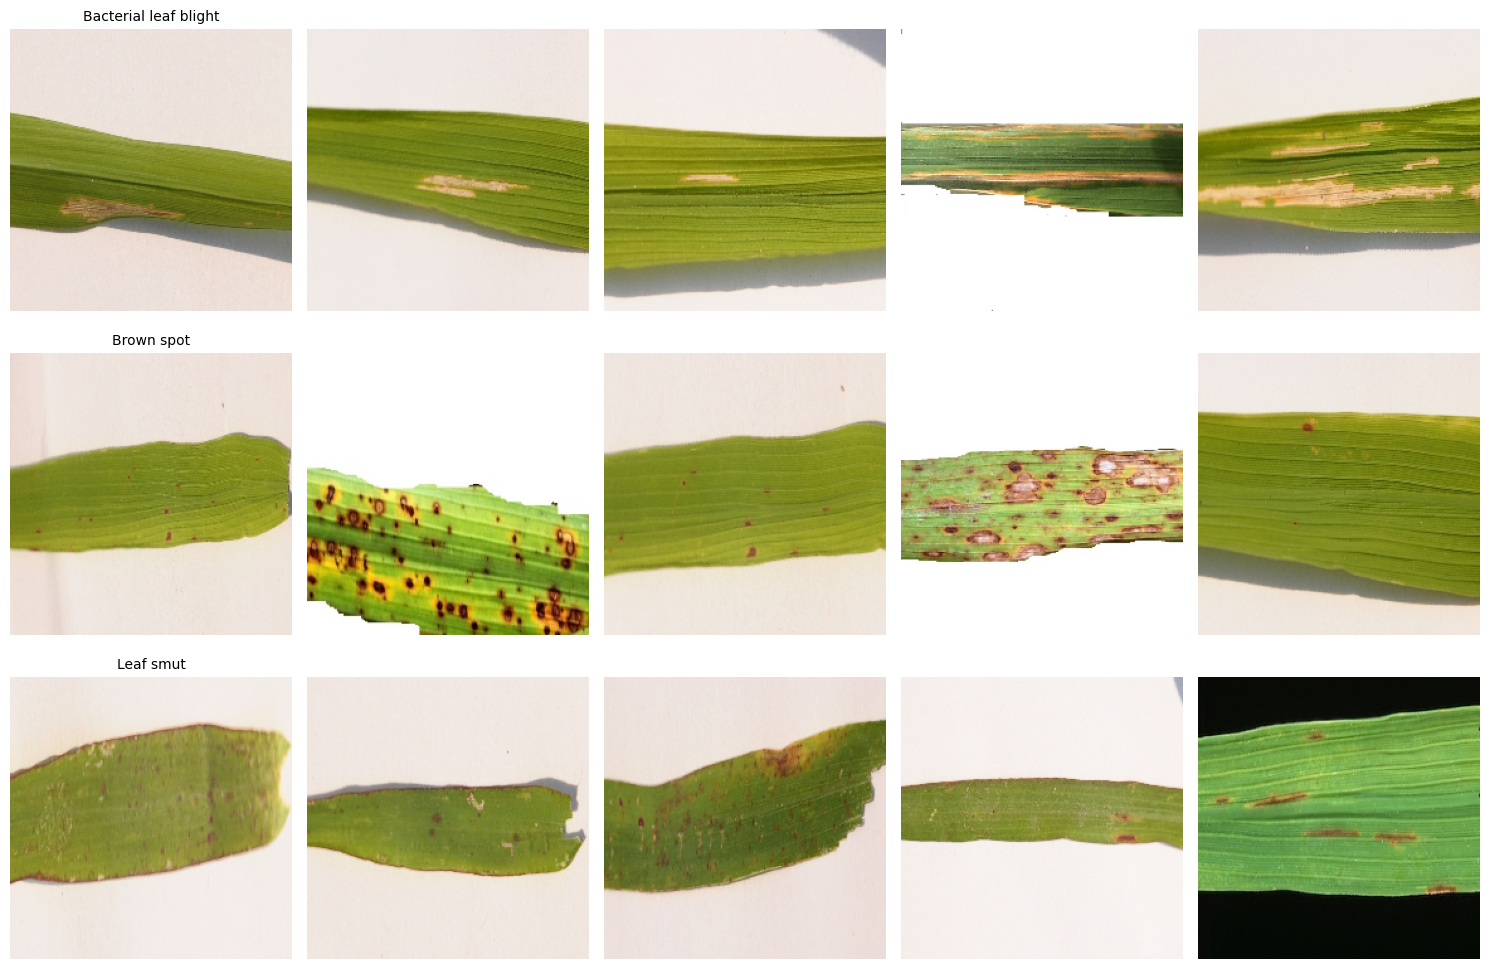

In [ ]:
plot_sample_images(X, y, class_names)

## Data analysis

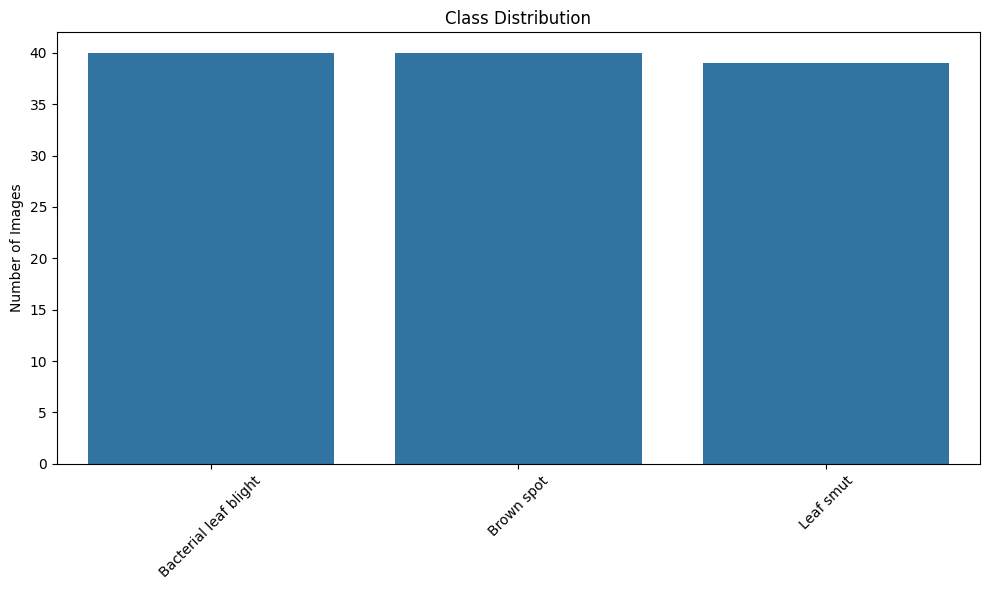

Class distribution:
Bacterial leaf blight: 40 images
Brown spot: 40 images
Leaf smut: 39 images


In [ ]:
# plotting class distribution
class_counts = np.bincount(y)
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_counts)
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Class distribution:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_counts[i]} images")

In [ ]:
# Image analysis statistics
def analyze_image_statistics(x):
    """Analyze basic statistics of the image dataset"""
    # Average brightness
    brightness = np.mean(x, axis=(1, 2, 3))

    # Standard deviation (contrast)
    contrast = np.std(x, axis=(1, 2, 3))

    # RGB channel averages
    r_channel = np.mean(x[:, :, :, 0], axis=(1, 2))
    g_channel = np.mean(x[:, :, :, 1], axis=(1, 2))
    b_channel = np.mean(x[:, :, :, 2], axis=(1, 2))

    stats = pd.DataFrame({
        'Brightness': brightness,
        'Contrast': contrast,
        'Red Channel': r_channel,
        'Green Channel': g_channel,
        'Blue Channel': b_channel
    })

    return stats

In [ ]:
image_stats = analyze_image_statistics(x)

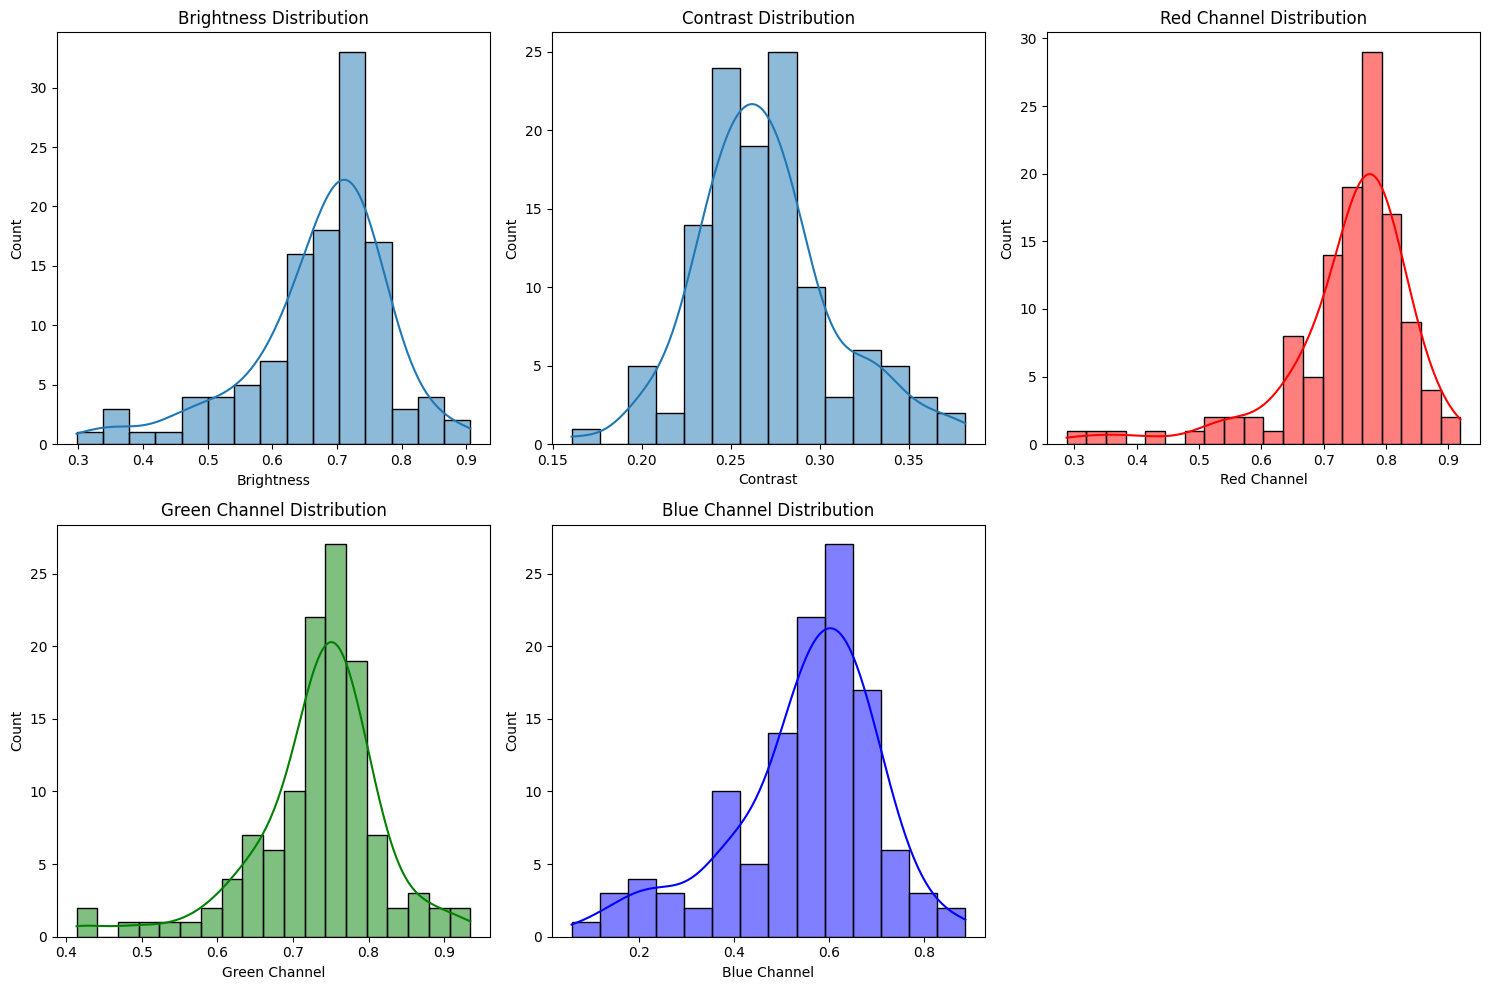

In [ ]:
# Plot image statistics
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(image_stats['Brightness'], kde=True)
plt.title('Brightness Distribution')

plt.subplot(2, 3, 2)
sns.histplot(image_stats['Contrast'], kde=True)
plt.title('Contrast Distribution')

plt.subplot(2, 3, 3)
sns.histplot(image_stats['Red Channel'], kde=True, color='red')
plt.title('Red Channel Distribution')

plt.subplot(2, 3, 4)
sns.histplot(image_stats['Green Channel'], kde=True, color='green')
plt.title('Green Channel Distribution')

plt.subplot(2, 3, 5)
sns.histplot(image_stats['Blue Channel'], kde=True, color='blue')
plt.title('Blue Channel Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze statistics by class
y_df = pd.Series(y, name='Class')
stats_by_class = pd.concat([image_stats, y_df], axis=1)

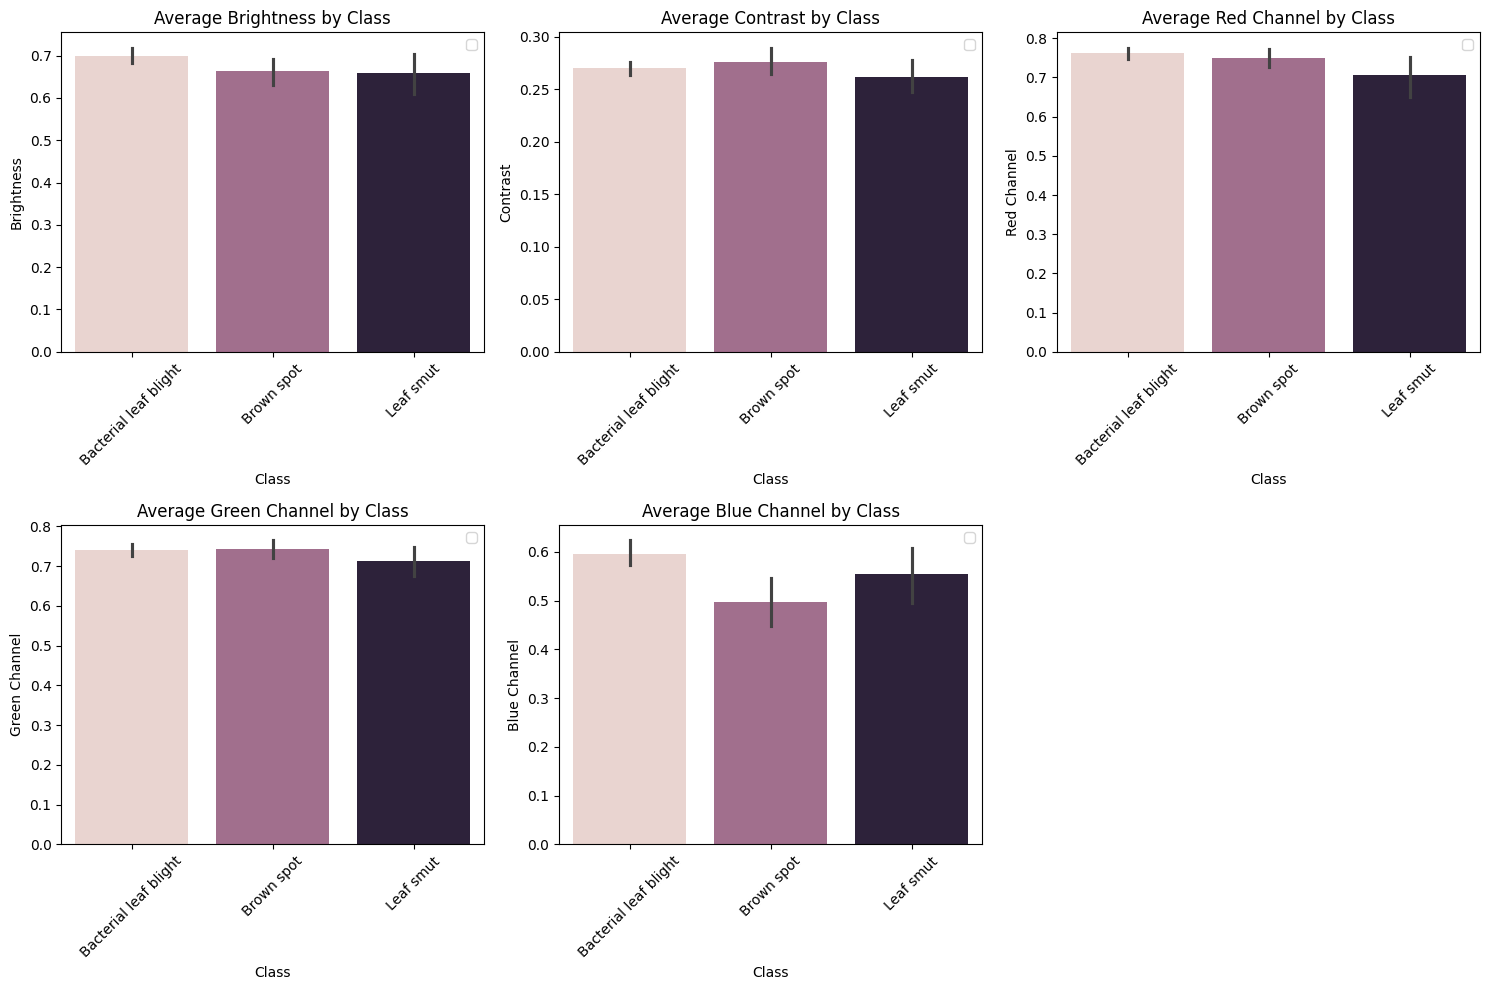

In [ ]:
# Plot average statistics by class
plt.figure(figsize=(15, 10))

features = ['Brightness', 'Contrast', 'Red Channel', 'Green Channel', 'Blue Channel']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Class', y=feature, data=stats_by_class, hue='Class')
    plt.title(f'Average {feature} by Class')
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
    plt.legend([])

plt.tight_layout()
plt.show()

## Data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,           # Rotate images randomly by up to 30 degrees
    width_shift_range=0.2,       # Shift images horizontally by up to 20%
    height_shift_range=0.2,      # Shift images vertically by up to 20%
    shear_range=0.2,             # Apply shear transformation with max angle 20 degrees
    zoom_range=0.2,              # Randomly zoom images by up to 20%
    horizontal_flip=True,        # Flip images horizontally
    fill_mode='nearest'         # Fill in newly created pixels with nearest pixel values

    )




In [ ]:
# Visualize augmented images
def plot_augmented_images(x_sample, datagen, n_augmentations=5):
    """Visualize augmented versions of an image"""
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, n_augmentations+1, 1)
    plt.imshow(x_sample)
    plt.title('Original')
    plt.axis('off')

    # Generate augmented images
    x_sample = np.expand_dims(x_sample, axis=0)  # Add batch dimension
    for i in range(1, n_augmentations + 1):
        augmented_image = datagen.random_transform(x_sample[0])  # Apply random transformation
        plt.subplot(1, n_augmentations + 1, i + 1)
        plt.imshow(augmented_image)
        plt.title(f'Augmentation {i}')
        plt.axis('off')

    plt.show()


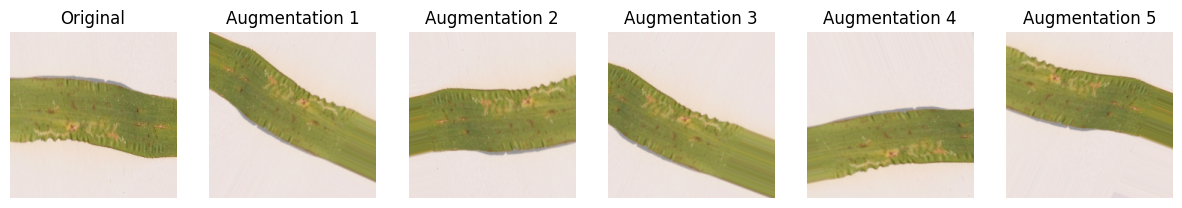

In [ ]:
plot_augmented_images(x_test[0], datagen, n_augmentations=5)

## Building and compiling models

In [ ]:
# function to create and compile models
def create_model(model_name, input_shape, num_classes):
    """Create and compile a model based on the model name"""

    if model_name == 'simple_cnn':
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    elif model_name == 'complex_cnn':
        model = Sequential([
            Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
            BatchNormalization(),
            Conv2D(32, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Conv2D(64, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            Conv2D(64, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Conv2D(128, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            Conv2D(128, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    elif model_name == 'vgg16_transfer':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False  # Freeze the base model

        model = Sequential([
            base_model,
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    elif model_name == 'resnet50_transfer':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False  # Freeze the base model

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    elif model_name == 'mobilenetv2_transfer':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False  # Freeze the base model

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Define callbacks
def get_callbacks(model_name):
    """Create callbacks for training"""
    checkpoint = ModelCheckpoint(
        f'best_{model_name}.h5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    return [checkpoint, early_stopping]

## Training and evaluation


Training simple_cnn model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_simple_cnn.h5



Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: val_accuracy improved from 0.50000 to 0.55556, saving model to best_simple_cnn.h5



Epoch 4: val_accuracy improved from 0.55556 to 0.72222, saving model to best_simple_cnn.h5



Epoch 5: val_accuracy did not improve from 0.72222

Epoch 6: val_accuracy improved from 0.72222 to 0.77778, saving model to best_simple_cnn.h5



Epoch 7: val_accuracy did not improve from 0.77778

Epoch 8: val_accuracy did not improve from 0.77778

Epoch 9: val_accuracy did not improve from 0.77778

Epoch 10: val_accuracy did not improve from 0.77778

Epoch 11: val_accuracy did not improve from 0.77778

Epoch 12: val_accuracy did not improve from 0.77778

Epoch 13: val_accuracy did not improve from 0.77778

Epoch 14: val_accuracy did not improve from 0.77778

Epoch 15: val_accuracy did not improve from 0.77778

Epoch 16: val_accuracy did not improve from 0.77778
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.

Test accuracy: 0.7222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.75      1.00      0.86         6
           Brown spot       0.75      0.50      0.60         6
            Leaf smut       0.67      0.67      0.67         6

             accuracy                           0

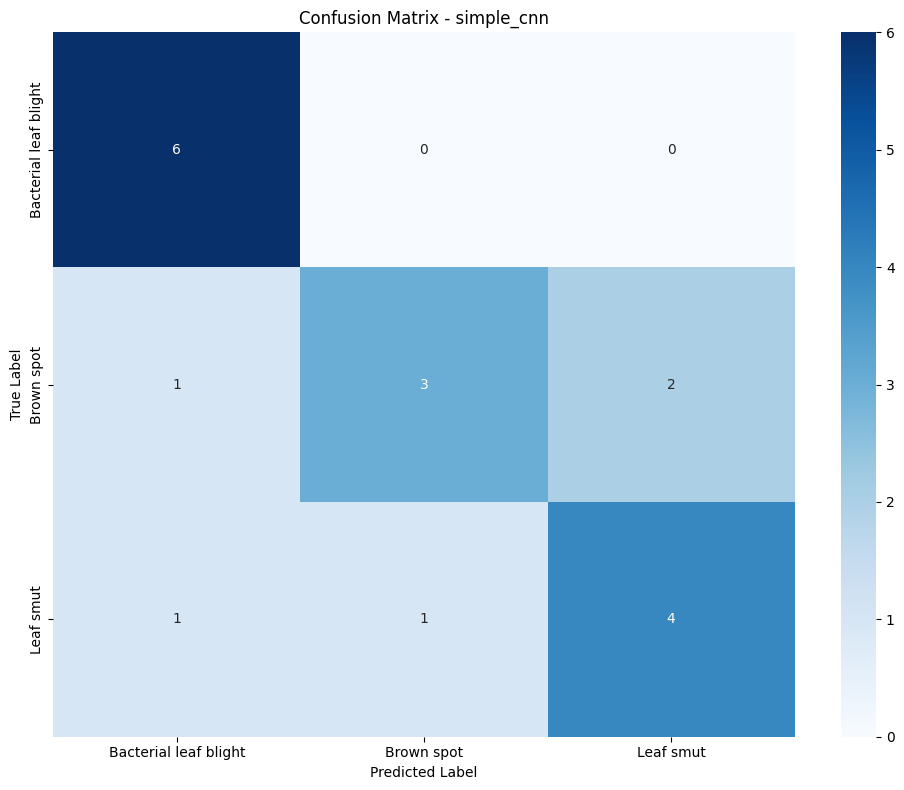

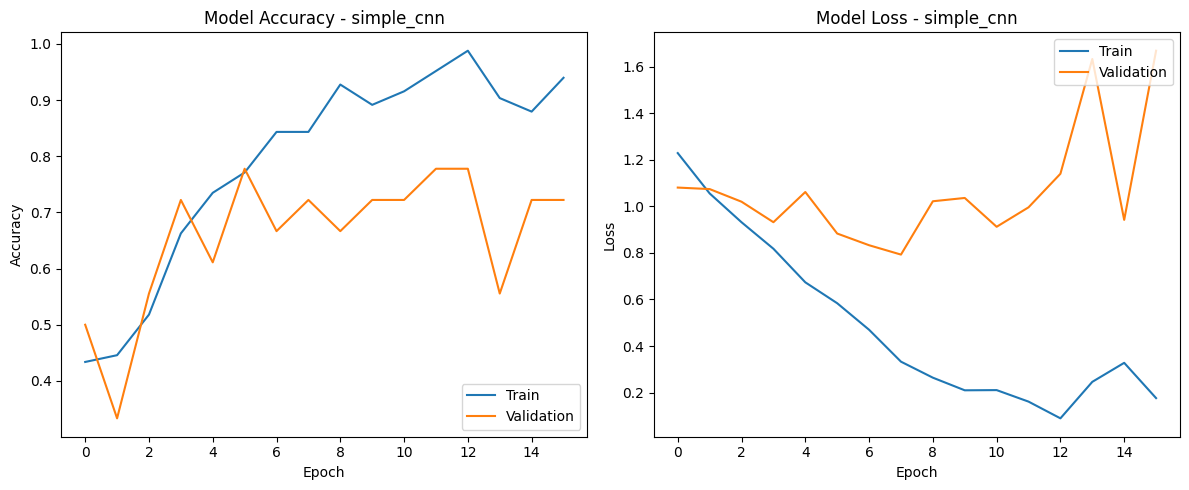


Training complex_cnn model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 25,980,963 (99.11 MB)

 Trainable params: 25,979,555 (99.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

None

Epoch 1: val_accuracy improved from -inf to 0.27778, saving model to best_complex_cnn.h5



Epoch 2: val_accuracy improved from 0.27778 to 0.33333, saving model to best_complex_cnn.h5



Epoch 3: val_accuracy did not improve from 0.33333

Epoch 4: val_accuracy did not improve from 0.33333

Epoch 5: val_accuracy did not improve from 0.33333

Epoch 6: val_accuracy did not improve from 0.33333

Epoch 7: val_accuracy did not improve from 0.33333

Epoch 8: val_accuracy did not improve from 0.33333

Epoch 9: val_accuracy did not improve from 0.33333

Epoch 10: val_accuracy did not improve from 0.33333

Epoch 11: val_accuracy did not improve from 0.33333

Epoch 12: val_accuracy did not improve from 0.33333
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.

Test accuracy: 0.3333
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.33      1.00      0.50         6
           Brown spot       0.00      0.00      0.00         6
            Leaf smut       0.00      0.00      0.00         6

             accuracy                           0.33 

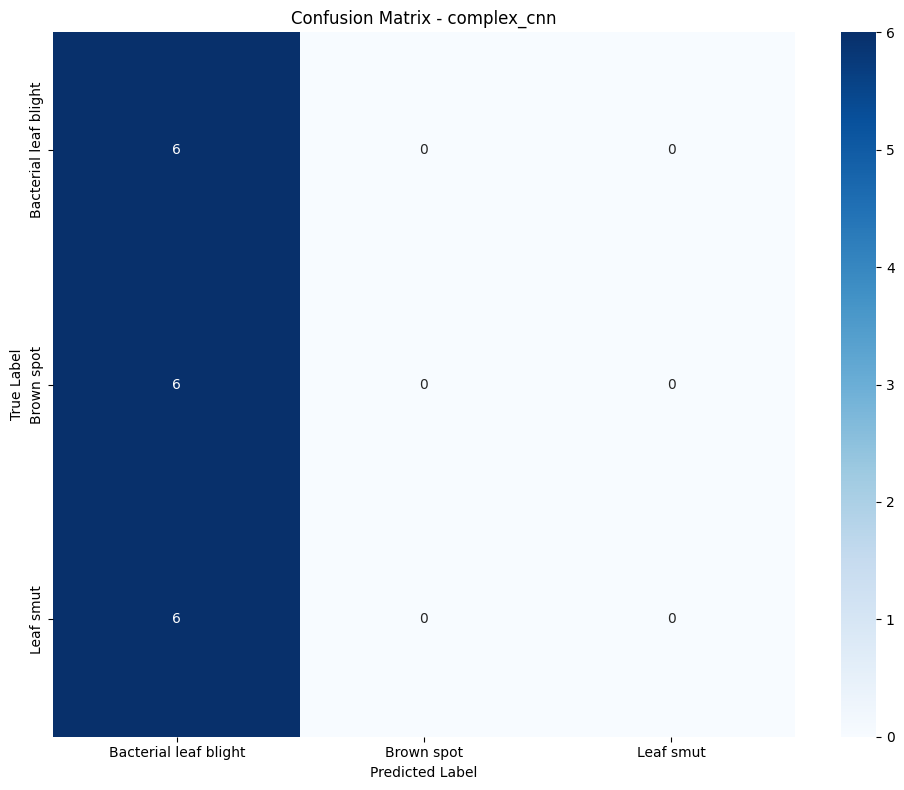

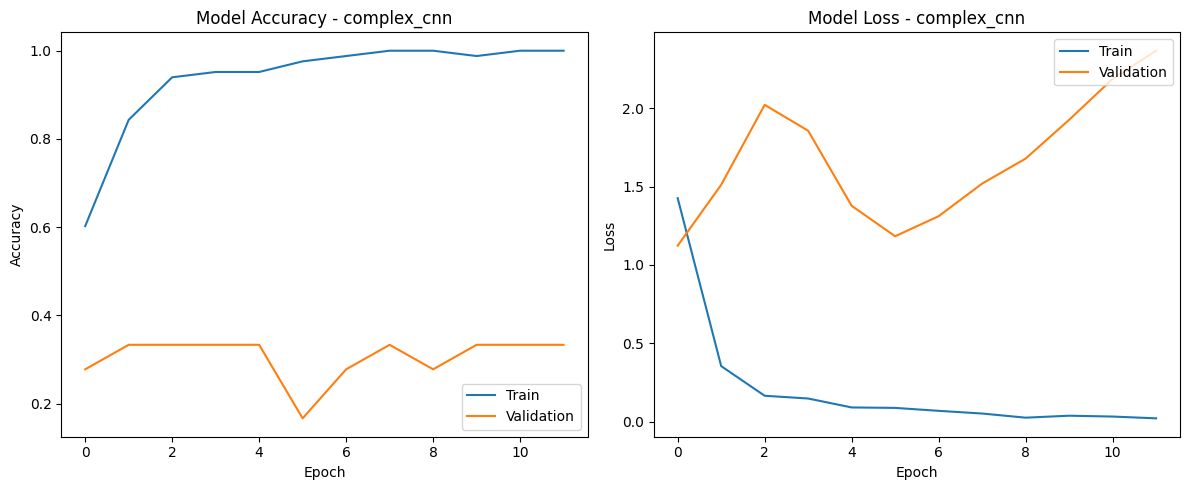


Training vgg16_transfer model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,267 (80.64 MB)

 Trainable params: 6,424,067 (24.51 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

None

Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to best_vgg16_transfer.h5



Epoch 2: val_accuracy did not improve from 0.44444

Epoch 3: val_accuracy did not improve from 0.44444

Epoch 4: val_accuracy did not improve from 0.44444

Epoch 5: val_accuracy did not improve from 0.44444

Epoch 6: val_accuracy did not improve from 0.44444

Epoch 7: val_accuracy improved from 0.44444 to 0.50000, saving model to best_vgg16_transfer.h5



Epoch 8: val_accuracy did not improve from 0.50000

Epoch 9: val_accuracy improved from 0.50000 to 0.55556, saving model to best_vgg16_transfer.h5



Epoch 10: val_accuracy did not improve from 0.55556

Epoch 11: val_accuracy did not improve from 0.55556

Epoch 12: val_accuracy did not improve from 0.55556

Epoch 13: val_accuracy improved from 0.55556 to 0.61111, saving model to best_vgg16_transfer.h5



Epoch 14: val_accuracy improved from 0.61111 to 0.72222, saving model to best_vgg16_transfer.h5



Epoch 15: val_accuracy did not improve from 0.72222
Restoring model weights from the end of the best epoch: 14.

Test accuracy: 0.7778
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.60      1.00      0.75         6
           Brown spot       1.00      0.50      0.67         6
            Leaf smut       1.00      0.83      0.91         6

             accuracy                           0.78        18
            macro avg       0.87      0.78      0.78        18
         weighted avg       0.87      0.78      0.78        18



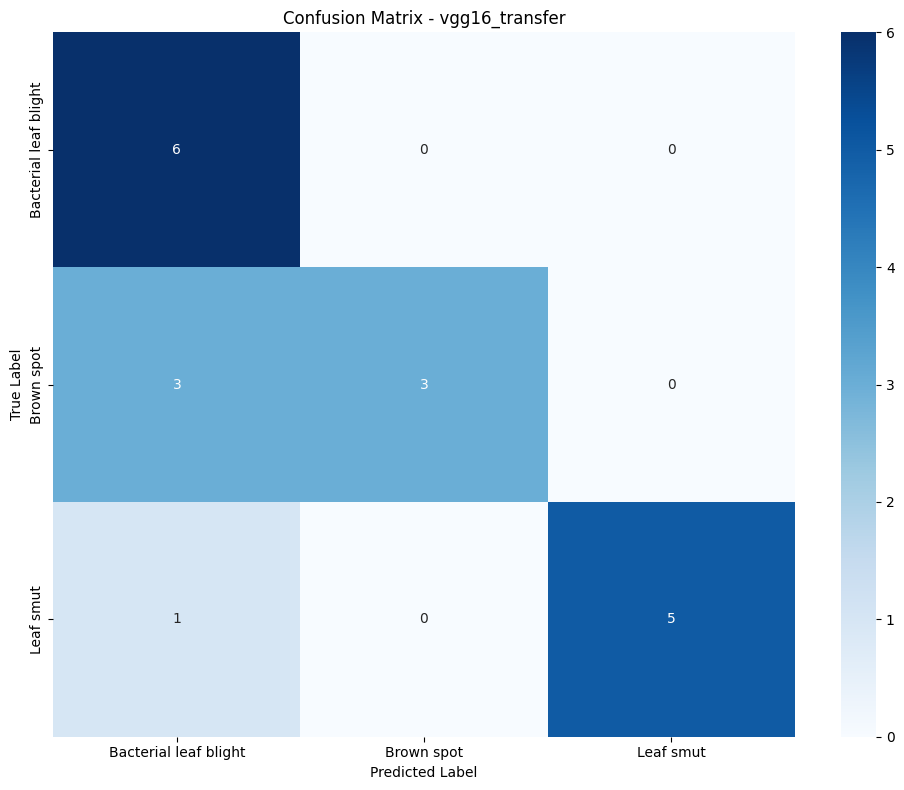

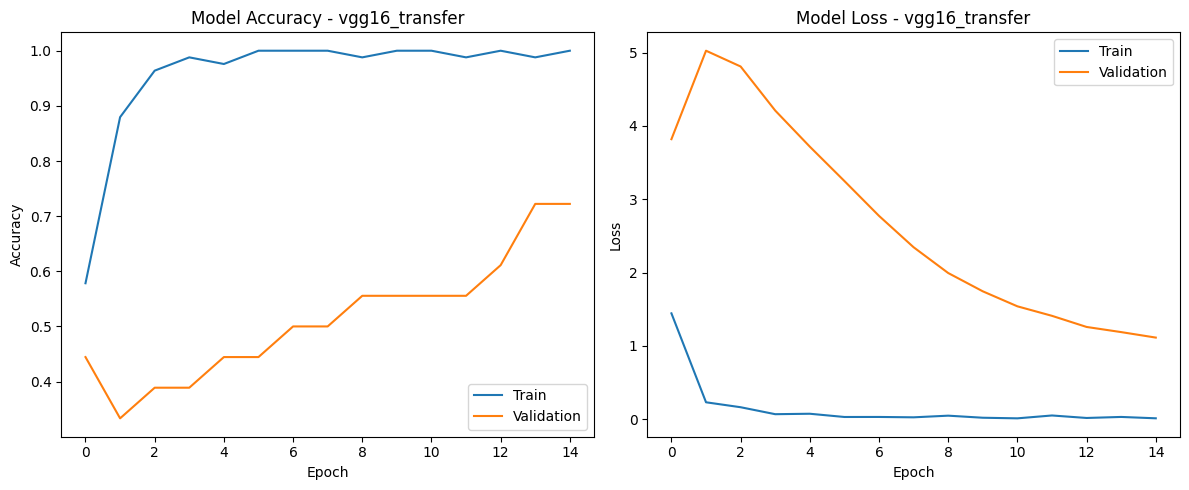


Training mobilenetv2_transfer model


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None

Epoch 1: val_accuracy improved from -inf to 0.72222, saving model to best_mobilenetv2_transfer.h5



Epoch 2: val_accuracy improved from 0.72222 to 0.77778, saving model to best_mobilenetv2_transfer.h5



Epoch 3: val_accuracy did not improve from 0.77778

Epoch 4: val_accuracy did not improve from 0.77778

Epoch 5: val_accuracy improved from 0.77778 to 0.83333, saving model to best_mobilenetv2_transfer.h5



Epoch 6: val_accuracy did not improve from 0.83333

Epoch 7: val_accuracy did not improve from 0.83333

Epoch 8: val_accuracy did not improve from 0.83333

Epoch 9: val_accuracy did not improve from 0.83333

Epoch 10: val_accuracy did not improve from 0.83333

Epoch 11: val_accuracy improved from 0.83333 to 0.88889, saving model to best_mobilenetv2_transfer.h5



Epoch 12: val_accuracy did not improve from 0.88889

Epoch 13: val_accuracy did not improve from 0.88889

Epoch 14: val_accuracy did not improve from 0.88889

Epoch 15: val_accuracy improved from 0.88889 to 0.94444, saving model to best_mobilenetv2_transfer.h5



Epoch 16: val_accuracy did not improve from 0.94444

Epoch 17: val_accuracy did not improve from 0.94444

Epoch 18: val_accuracy did not improve from 0.94444

Epoch 19: val_accuracy did not improve from 0.94444

Epoch 20: val_accuracy did not improve from 0.94444

Epoch 21: val_accuracy did not improve from 0.94444

Epoch 22: val_accuracy did not improve from 0.94444

Epoch 23: val_accuracy did not improve from 0.94444

Epoch 24: val_accuracy did not improve from 0.94444

Epoch 25: val_accuracy did not improve from 0.94444
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.

Test accuracy: 0.8333
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.86      1.00      0.92         6
           Brown spot       0.80      0.67      0.73         6
            Leaf smut       0.83      0.83      0.83         6

             accuracy                           

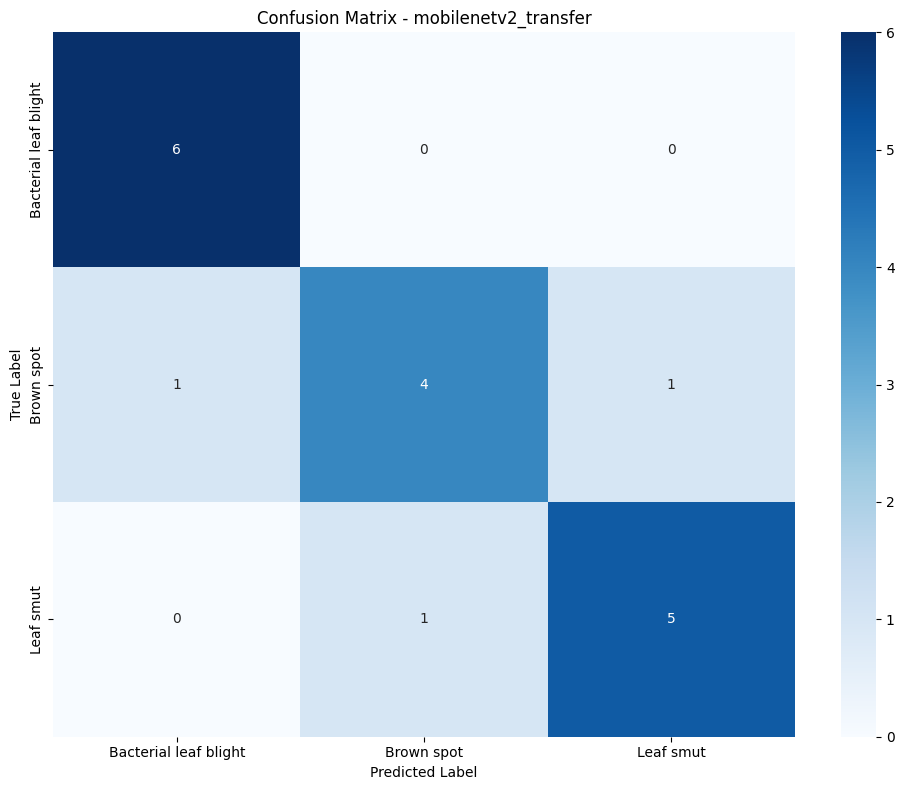

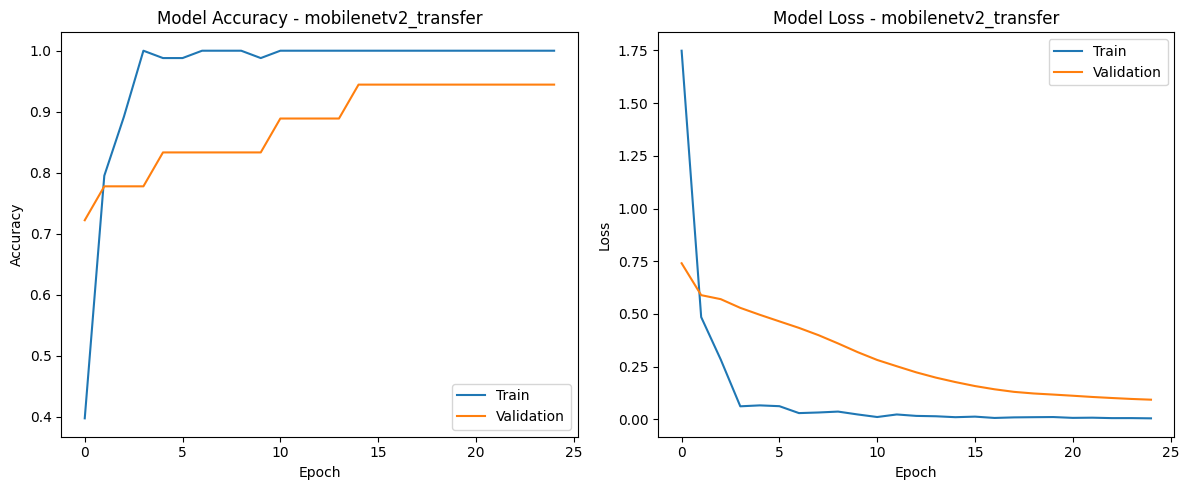


Training resnet50_transfer model


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,051 (91.99 MB)

 Trainable params: 525,827 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

None

Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_resnet50_transfer.h5



Epoch 2: val_accuracy did not improve from 0.33333

Epoch 3: val_accuracy did not improve from 0.33333

Epoch 4: val_accuracy did not improve from 0.33333

Epoch 5: val_accuracy did not improve from 0.33333

Epoch 6: val_accuracy did not improve from 0.33333

Epoch 7: val_accuracy did not improve from 0.33333

Epoch 8: val_accuracy did not improve from 0.33333

Epoch 9: val_accuracy did not improve from 0.33333

Epoch 10: val_accuracy did not improve from 0.33333

Epoch 11: val_accuracy did not improve from 0.33333
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Test accuracy: 0.3333


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.33      1.00      0.50         6
           Brown spot       0.00      0.00      0.00         6
            Leaf smut       0.00      0.00      0.00         6

             accuracy                           0.33        18
            macro avg       0.11      0.33      0.17        18
         weighted avg       0.11      0.33      0.17        18



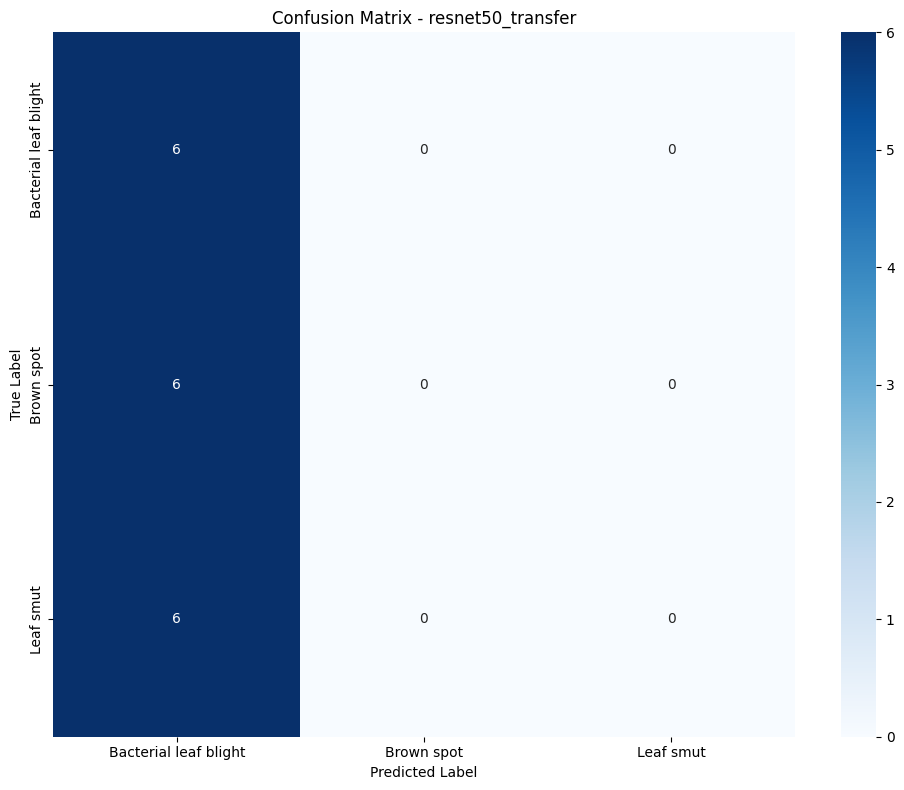

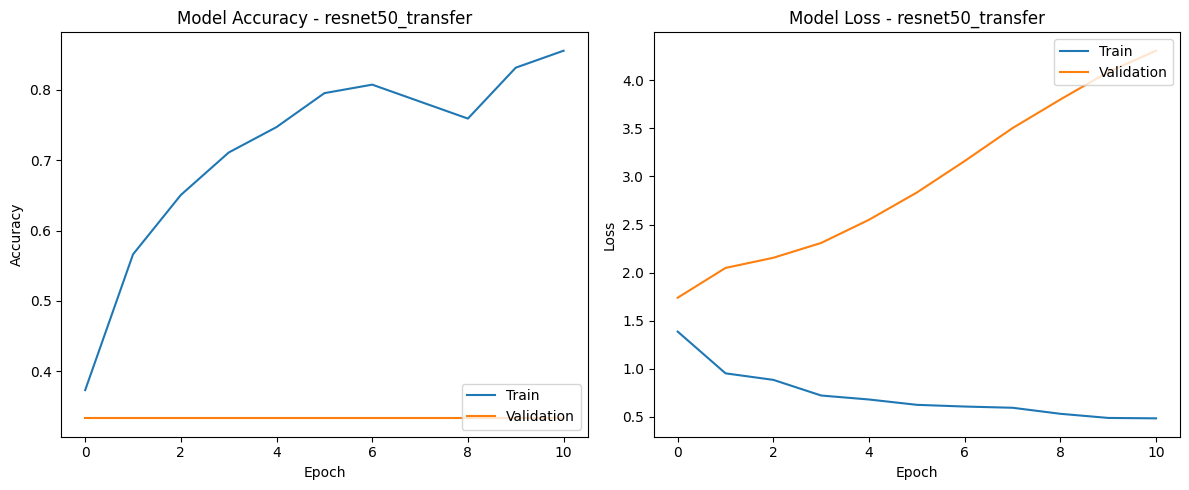

In [ ]:
# Function to train and evaluate models
def train_and_evaluate_model(model_name, x_train, y_train_cat, x_val, y_val_cat, x_test, y_test_cat, class_names, epochs=30, batch_size=32):
    """Train and evaluate a model"""
    print(f"\n{'='*50}")
    print(f"Training {model_name} model")
    print(f"{'='*50}")

    # Create model
    model = create_model(model_name, x_train.shape[1:], len(class_names))
    print(model.summary())

    # Get callbacks
    callbacks = get_callbacks(model_name)

    # Train model
    history = model.fit(
        x_train, y_train_cat,
        validation_data=(x_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest accuracy: {test_acc:.4f}")

    # Predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

    return {
        'model_name': model_name,
        'test_accuracy': test_acc,
        'model': model,
        'y_pred_classes': y_pred_classes,
        'y_test_classes': y_test_classes,
        'history': history.history
    }

# Train models
model_results = []

# Simple CNN
simple_cnn_results = train_and_evaluate_model(
    'simple_cnn',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=20,  # Reduced epochs for demonstration
    batch_size=32
)
model_results.append(simple_cnn_results)

# Complex CNN
complex_cnn_results = train_and_evaluate_model(
    'complex_cnn',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=20,  # Reduced epochs for demonstration
    batch_size=32
)
model_results.append(complex_cnn_results)

# VGG16 Transfer Learning
vgg16_results = train_and_evaluate_model(
    'vgg16_transfer',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=15,  # Reduced epochs for demonstration
    batch_size=16  # Smaller batch size for larger model
)
model_results.append(vgg16_results)


# Train MobileNetV2 Transfer Learning Model
mobilenetv2_results = train_and_evaluate_model(
    'mobilenetv2_transfer',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=30,  # Adjust epochs based on your preference
    batch_size=32
)
model_results.append(mobilenetv2_results)


# Train ResNet50 Transfer Learning Model
resnet50_results = train_and_evaluate_model(
    'resnet50_transfer',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=30,  # Adjust epochs based on your preference
    batch_size=32
)
model_results.append(resnet50_results)


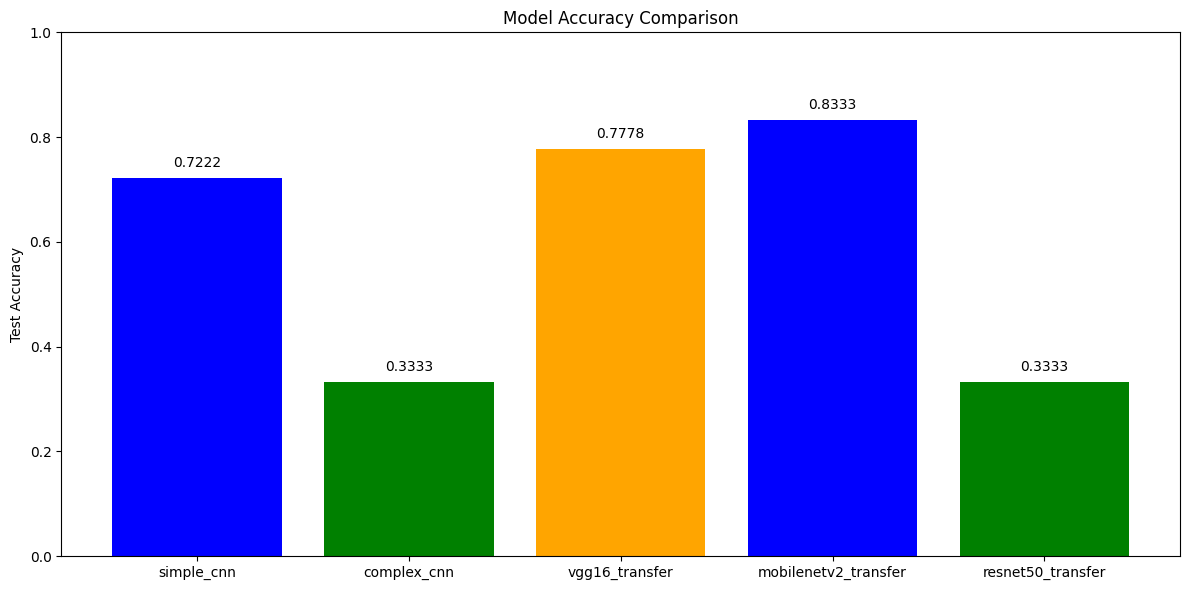


Model Comparison Table:
                  Model  Test Accuracy  Train Accuracy  Validation Accuracy  \
0            simple_cnn       0.722222        0.987952             0.777778   
1           complex_cnn       0.333333        1.000000             0.333333   
2        vgg16_transfer       0.777778        1.000000             0.722222   
3  mobilenetv2_transfer       0.833333        1.000000             0.944444   
4     resnet50_transfer       0.333333        0.855422             0.333333   

   Bacterial leaf blight F1-Score  Brown spot F1-Score  Leaf smut F1-Score  
0                        0.857143             0.600000            0.666667  
1                        0.500000             0.000000            0.000000  
2                        0.750000             0.666667            0.909091  
3                        0.923077             0.727273            0.833333  
4                        0.500000             0.000000            0.000000  

Best Model: mobilenetv2_transfer with

In [ ]:
# Comparing model performances
model_names = [result['model_name'] for result in model_results]
test_accuracies = [result['test_accuracy'] for result in model_results]

plt.figure(figsize=(12, 6))
plt.bar(model_names, test_accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(test_accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

# comparison table
comparison_data = []
for result in model_results:
    # Calculating class-wise metrics
    report = classification_report(
        result['y_test_classes'],
        result['y_pred_classes'],
        target_names=class_names,
        output_dict=True
    )

    # Get train and validation metrics
    train_acc = max(result['history']['accuracy'])
    val_acc = max(result['history']['val_accuracy'])

    comparison_data.append({
        'Model': result['model_name'],
        'Test Accuracy': result['test_accuracy'],
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        **{f"{cls} F1-Score": report[cls]['f1-score'] for cls in class_names}
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison Table:")
print(comparison_df)

# Finding best model
best_model_idx = np.argmax(test_accuracies)
best_model_name = model_names[best_model_idx]
best_model = model_results[best_model_idx]['model']

print(f"\nBest Model: {best_model_name} with Test Accuracy: {test_accuracies[best_model_idx]:.4f}")

## with data augmentation

In [ ]:
datagen.fit(x_train)  # Train data augmentation

val_datagen = ImageDataGenerator()  # No augmentation for validation data
val_datagen.fit(x_val)

In [ ]:
# function to create and compile models
def create_model(model_name, input_shape, num_classes):
    """Create and compile a model based on the model name"""

    if model_name == 'simple_cnn':
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.5),  # Increased dropout rate
            BatchNormalization(),  # Added Batch Normalization
            Dense(num_classes, activation='softmax')
        ])

    elif model_name == 'complex_cnn': # Corrected indentation here
        model = Sequential([
            Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
            BatchNormalization(),
            Conv2D(32, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Conv2D(64, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            Conv2D(64, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Conv2D(128, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            Conv2D(128, (3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    elif model_name == 'vgg16_transfer':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False  # Freeze the base model

        model = Sequential([
            base_model,
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    elif model_name == 'resnet50_transfer':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False  # Freeze the base model

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    elif model_name == 'mobilenetv2_transfer':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False  # Freeze the base model

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0008),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


Training simple_cnn model


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,859 (42.61 MB)

 Trainable params: 11,169,603 (42.61 MB)

 Non-trainable params: 256 (1.00 KB)

None

Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_simple_cnn.h5



Epoch 2: val_accuracy did not improve from 0.33333

Epoch 3: val_accuracy improved from 0.33333 to 0.44444, saving model to best_simple_cnn.h5



Epoch 4: val_accuracy did not improve from 0.44444

Epoch 5: val_accuracy did not improve from 0.44444

Epoch 6: val_accuracy did not improve from 0.44444

Epoch 7: val_accuracy did not improve from 0.44444

Epoch 8: val_accuracy did not improve from 0.44444

Epoch 9: val_accuracy did not improve from 0.44444

Epoch 10: val_accuracy did not improve from 0.44444

Epoch 11: val_accuracy did not improve from 0.44444

Epoch 12: val_accuracy did not improve from 0.44444

Epoch 13: val_accuracy did not improve from 0.44444
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Test accuracy: 0.5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.50      0.67      0.57         6
           Brown spot       0.00      0.00      0.00         6
            Leaf smut       0.50      0.83      0.62         6

             accuracy                           0.50

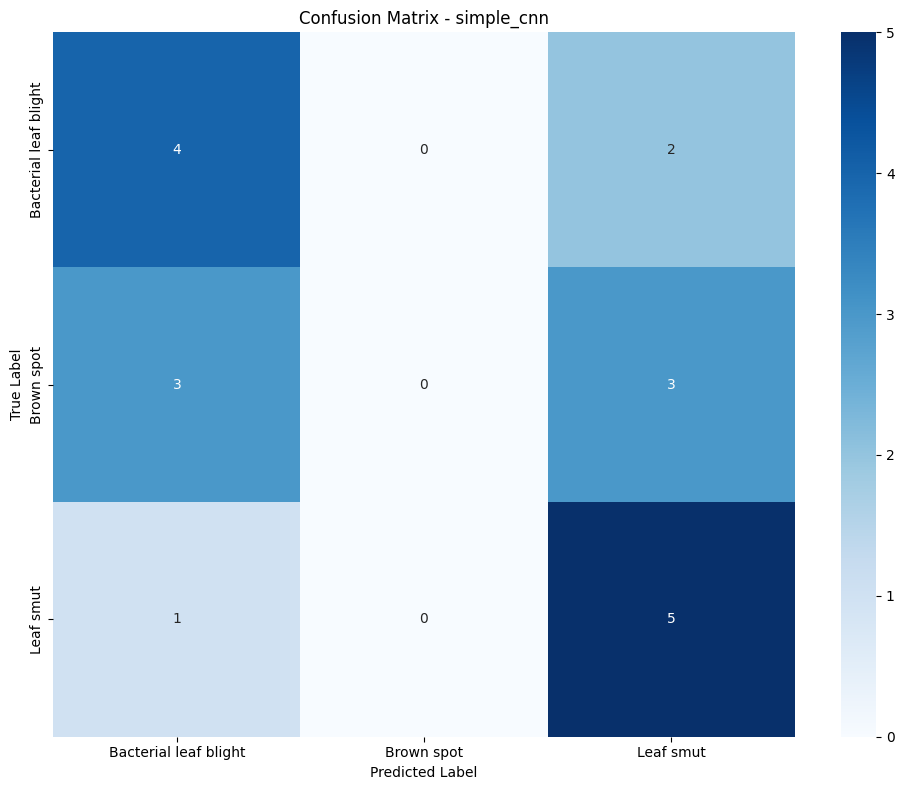

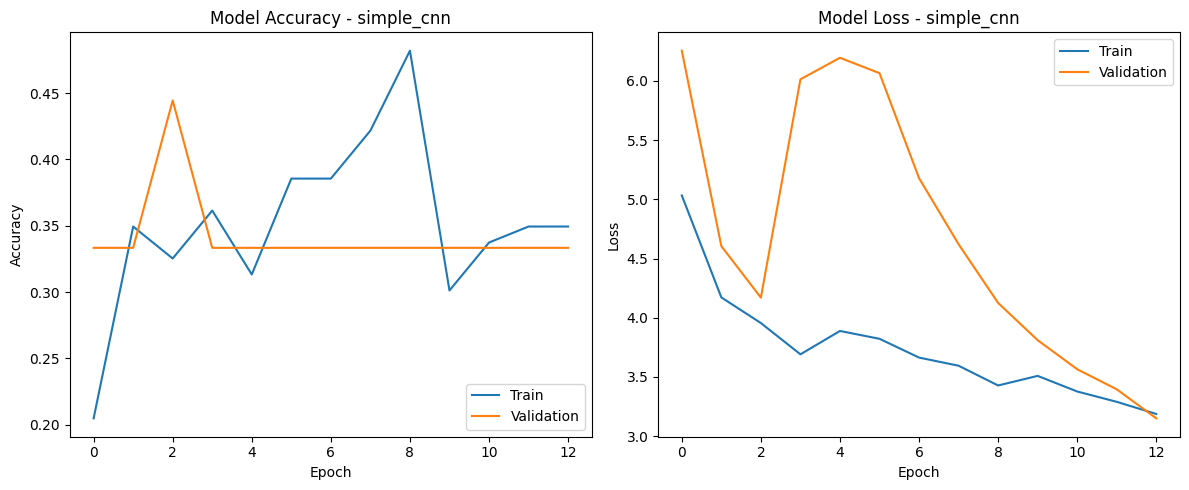


Training complex_cnn model


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 25,980,963 (99.11 MB)

 Trainable params: 25,979,555 (99.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

None

Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_complex_cnn.h5



Epoch 2: val_accuracy did not improve from 0.33333

Epoch 3: val_accuracy did not improve from 0.33333

Epoch 4: val_accuracy improved from 0.33333 to 0.38889, saving model to best_complex_cnn.h5



Epoch 5: val_accuracy did not improve from 0.38889

Epoch 6: val_accuracy did not improve from 0.38889

Epoch 7: val_accuracy did not improve from 0.38889

Epoch 8: val_accuracy did not improve from 0.38889

Epoch 9: val_accuracy did not improve from 0.38889

Epoch 10: val_accuracy did not improve from 0.38889

Epoch 11: val_accuracy did not improve from 0.38889

Epoch 12: val_accuracy did not improve from 0.38889

Epoch 13: val_accuracy did not improve from 0.38889

Epoch 14: val_accuracy did not improve from 0.38889
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 4.

Test accuracy: 0.2222
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.00      0.00      0.00         6
           Brown spot       0.25      0.50      0.33         6
            Leaf smut       0.17      0.17      0.17         6

             accuracy                           0.2

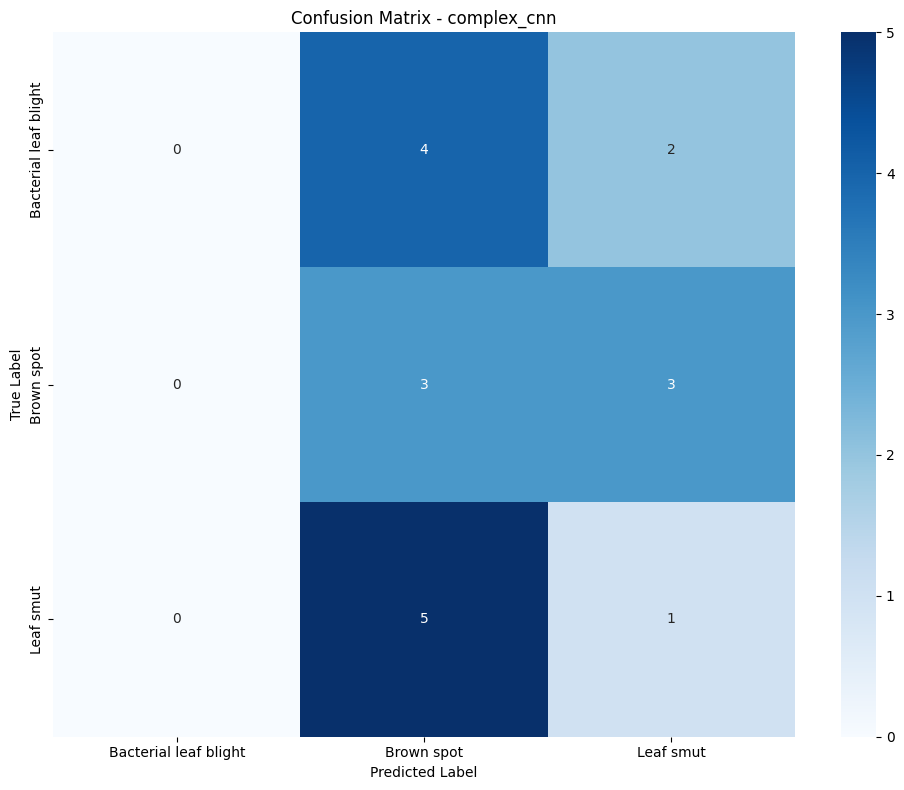

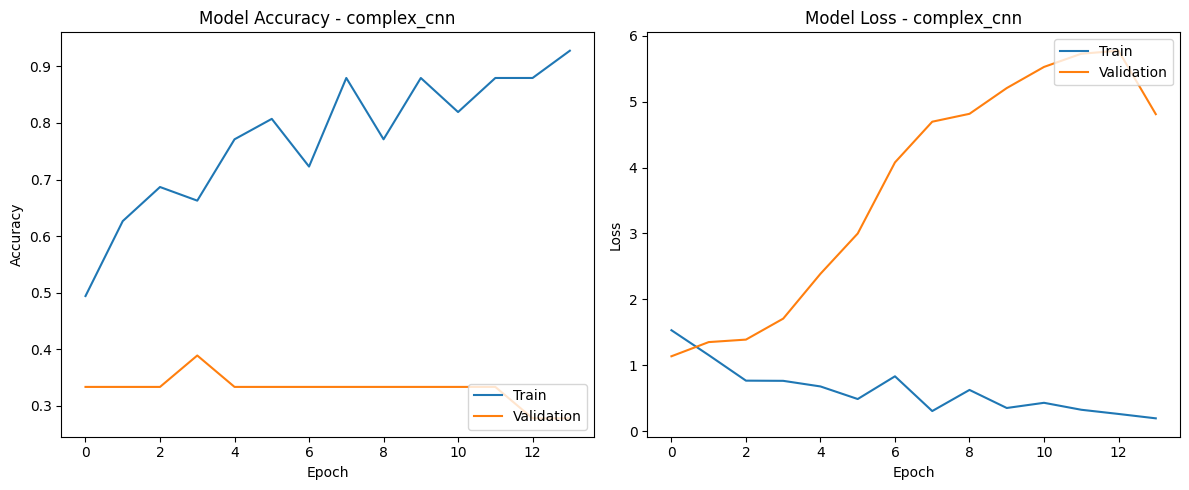


Training vgg16_transfer model


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,267 (80.64 MB)

 Trainable params: 6,424,067 (24.51 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

None

Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_vgg16_transfer.h5



Epoch 2: val_accuracy improved from 0.33333 to 0.55556, saving model to best_vgg16_transfer.h5



Epoch 3: val_accuracy improved from 0.55556 to 0.61111, saving model to best_vgg16_transfer.h5



Epoch 4: val_accuracy did not improve from 0.61111

Epoch 5: val_accuracy did not improve from 0.61111

Epoch 6: val_accuracy did not improve from 0.61111

Epoch 7: val_accuracy improved from 0.61111 to 0.66667, saving model to best_vgg16_transfer.h5



Epoch 8: val_accuracy did not improve from 0.66667

Epoch 9: val_accuracy did not improve from 0.66667

Epoch 10: val_accuracy improved from 0.66667 to 0.72222, saving model to best_vgg16_transfer.h5



Epoch 11: val_accuracy did not improve from 0.72222

Epoch 12: val_accuracy did not improve from 0.72222

Epoch 13: val_accuracy did not improve from 0.72222

Epoch 14: val_accuracy did not improve from 0.72222

Epoch 15: val_accuracy did not improve from 0.72222
Restoring model weights from the end of the best epoch: 10.

Test accuracy: 0.6111
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.55      1.00      0.71         6
           Brown spot       0.67      0.67      0.67         6
            Leaf smut       1.00      0.17      0.29         6

             accuracy                           0.61        18
            macro avg       0.74      0.61      0.55        18
         weighted avg       0.74      0.61      0.55        18



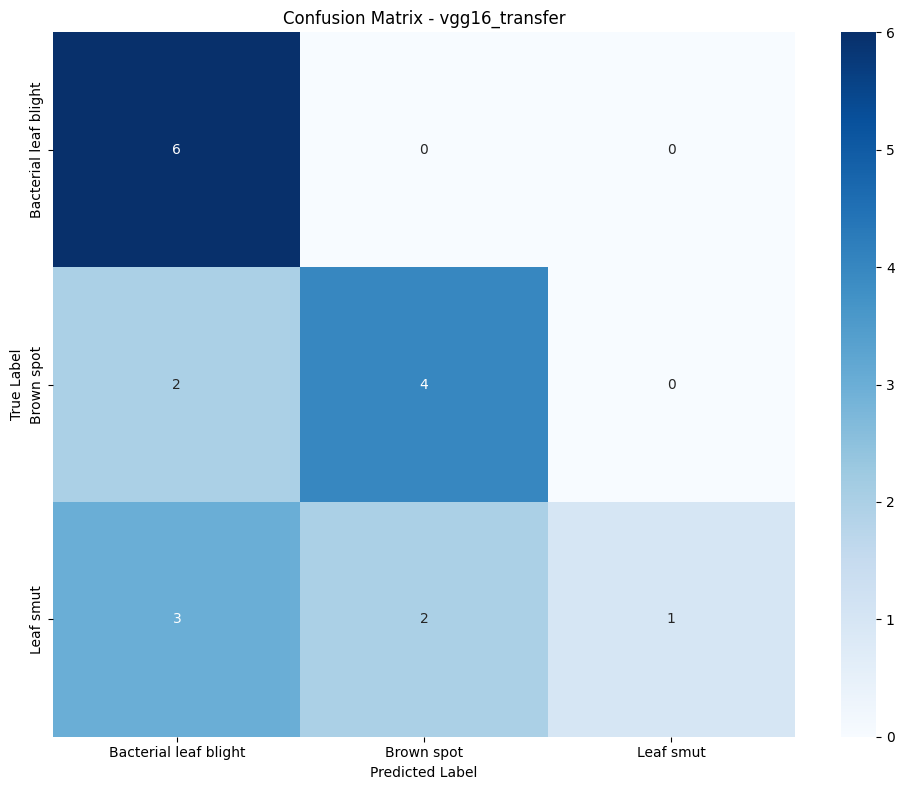

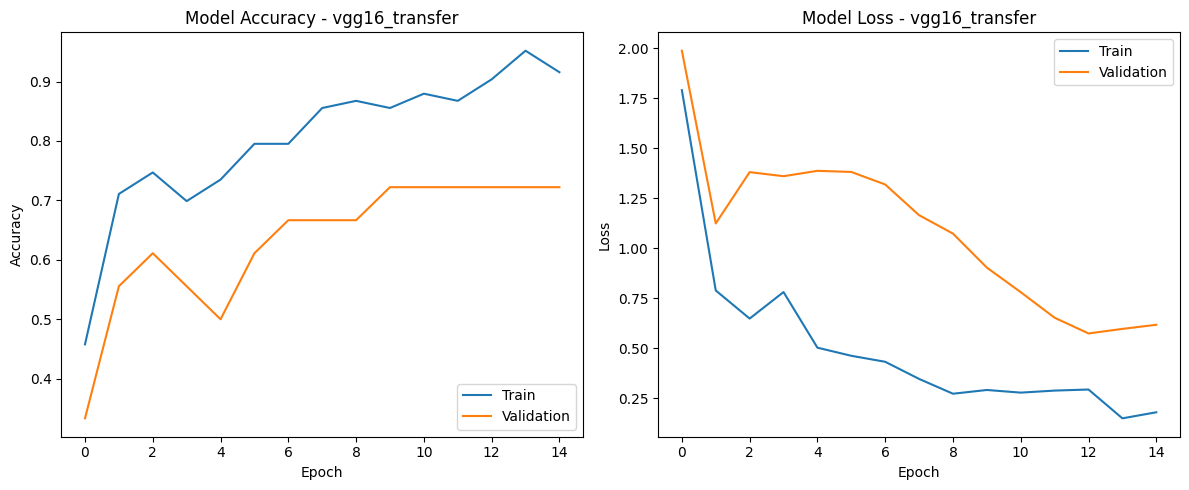


Training mobilenetv2_transfer model


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None

Epoch 1: val_accuracy improved from -inf to 0.61111, saving model to best_mobilenetv2_transfer.h5



Epoch 2: val_accuracy improved from 0.61111 to 0.66667, saving model to best_mobilenetv2_transfer.h5



Epoch 3: val_accuracy improved from 0.66667 to 0.72222, saving model to best_mobilenetv2_transfer.h5



Epoch 4: val_accuracy did not improve from 0.72222

Epoch 5: val_accuracy did not improve from 0.72222

Epoch 6: val_accuracy did not improve from 0.72222

Epoch 7: val_accuracy did not improve from 0.72222

Epoch 8: val_accuracy did not improve from 0.72222

Epoch 9: val_accuracy did not improve from 0.72222

Epoch 10: val_accuracy did not improve from 0.72222

Epoch 11: val_accuracy did not improve from 0.72222

Epoch 12: val_accuracy did not improve from 0.72222

Epoch 13: val_accuracy did not improve from 0.72222
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.

Test accuracy: 0.6667
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.83      0.91         6
           Brown spot       0.50      1.00      0.67         6
            Leaf smut       1.00      0.17      0.29         6

             accuracy                           0.67   

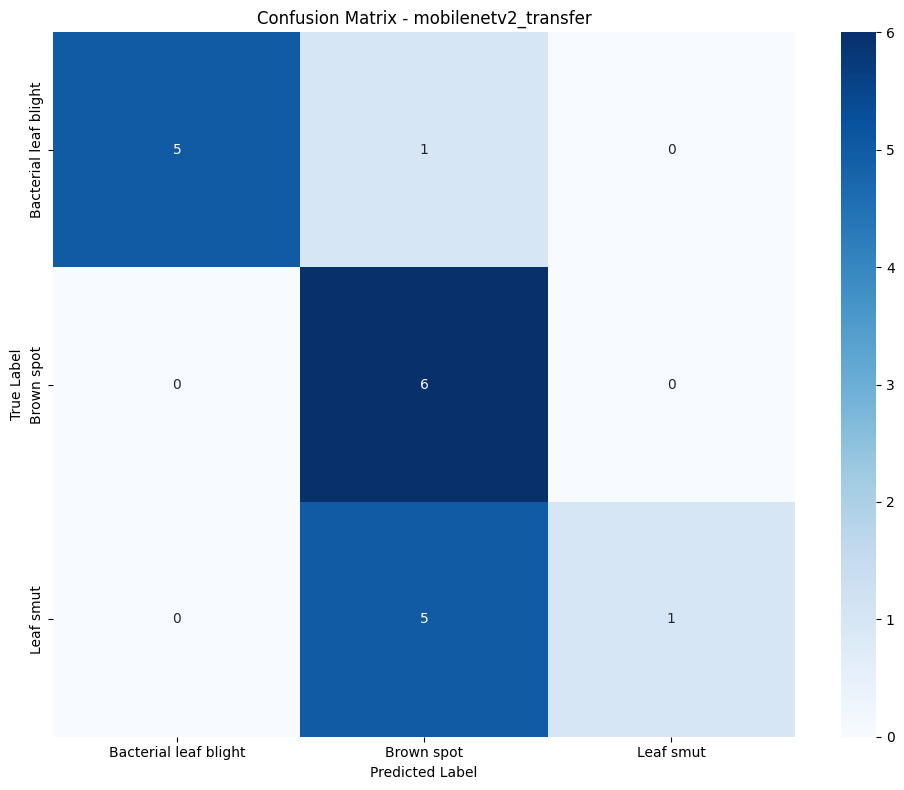

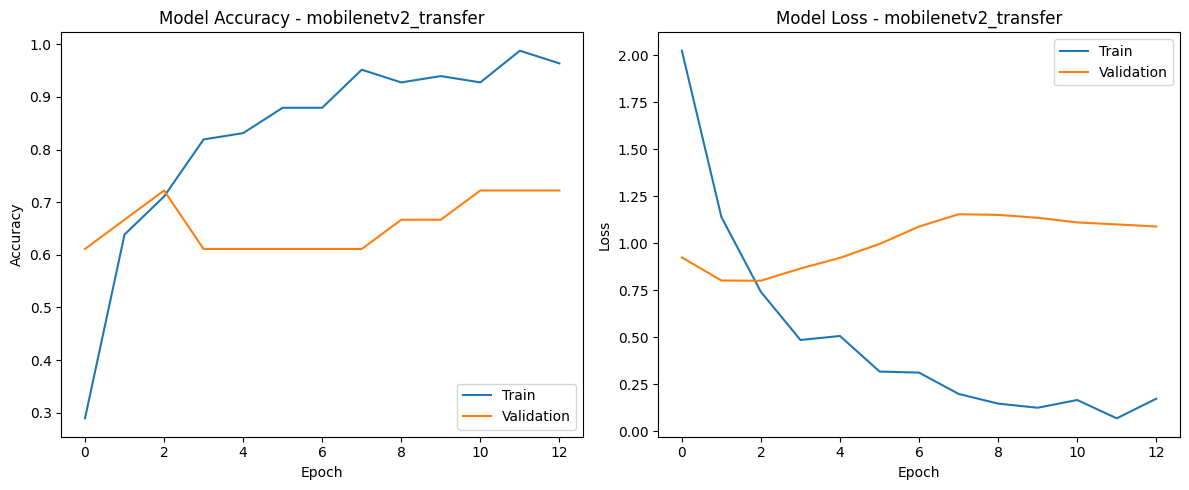


Training resnet50_transfer model


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,051 (91.99 MB)

 Trainable params: 525,827 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

None

Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_resnet50_transfer.h5



Epoch 2: val_accuracy did not improve from 0.33333

Epoch 3: val_accuracy did not improve from 0.33333

Epoch 4: val_accuracy did not improve from 0.33333

Epoch 5: val_accuracy did not improve from 0.33333

Epoch 6: val_accuracy did not improve from 0.33333

Epoch 7: val_accuracy did not improve from 0.33333

Epoch 8: val_accuracy did not improve from 0.33333

Epoch 9: val_accuracy did not improve from 0.33333

Epoch 10: val_accuracy did not improve from 0.33333

Epoch 11: val_accuracy did not improve from 0.33333
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.

Test accuracy: 0.3333
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.33      1.00      0.50         6
           Brown spot       0.00      0.00      0.00         6
            Leaf smut       0.00      0.00      0.00         6

             accuracy                           0.33     

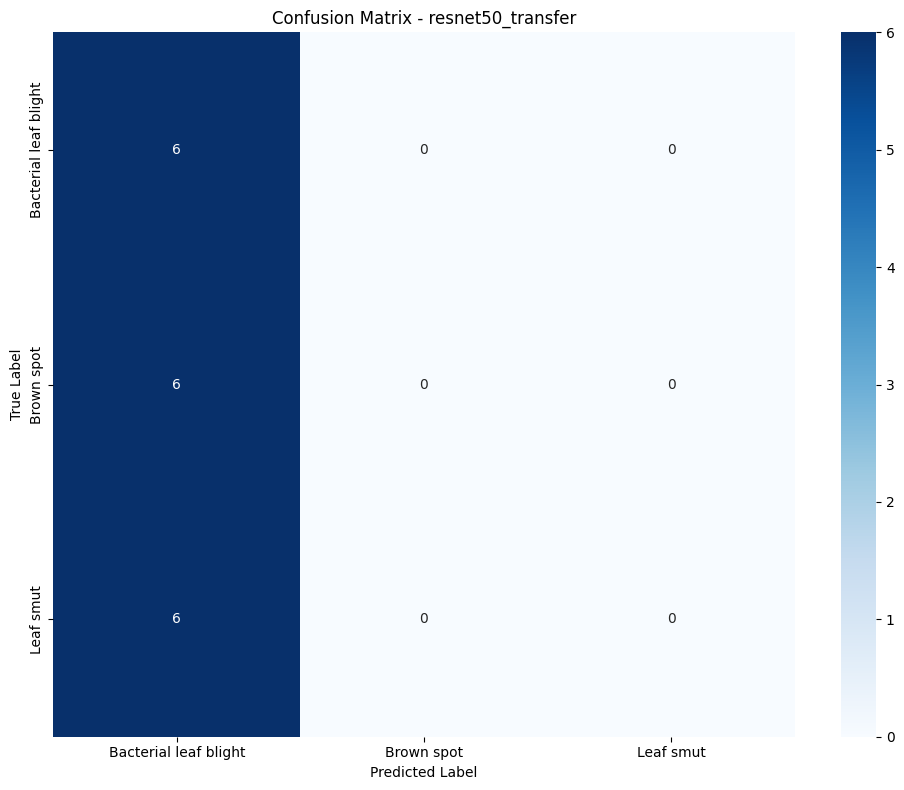

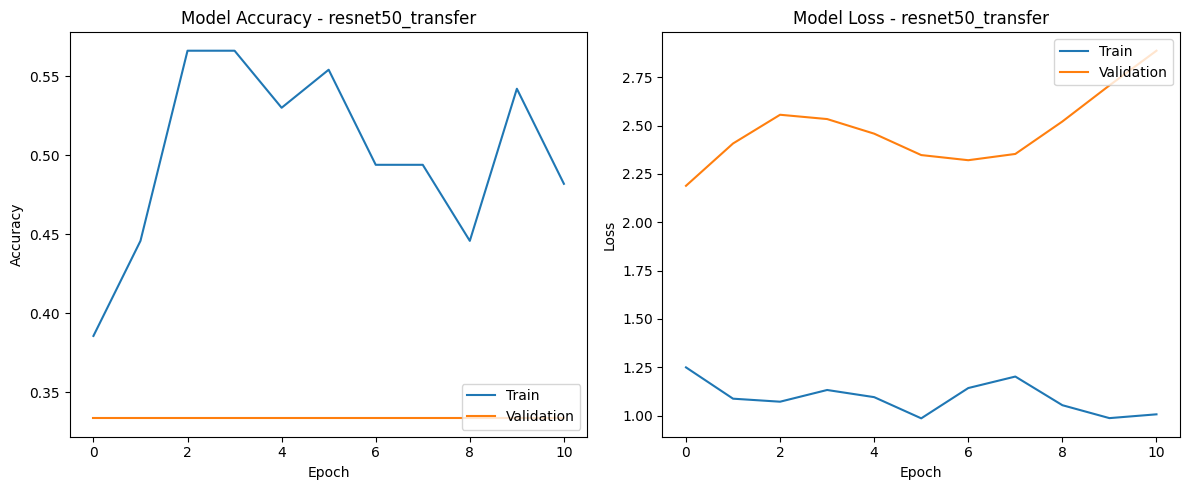

In [ ]:
# Function to train and evaluate models
def train_and_evaluate_model(model_name, x_train, y_train_cat, x_val, y_val_cat, x_test, y_test_cat, class_names, epochs=30, batch_size=32):
    """Train and evaluate a model"""
    print(f"\n{'='*50}")
    print(f"Training {model_name} model")
    print(f"{'='*50}")

    # Create model
    model = create_model(model_name, x_train.shape[1:], len(class_names))
    print(model.summary())

    # Get callbacks
    callbacks = get_callbacks(model_name)

    # Train model
    history = model.fit(
        datagen.flow(x_train, y_train_cat, batch_size=32),
        epochs=epochs,
        validation_data=(x_val, y_val_cat),
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )


    # Evaluate on test set
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest accuracy: {test_acc:.4f}")

    # Predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

    return {
        'model_name': model_name,
        'test_accuracy': test_acc,
        'model': model,
        'y_pred_classes': y_pred_classes,
        'y_test_classes': y_test_classes,
        'history': history.history
    }

# Train models
model_results = []

# Simple CNN
simple_cnn_results = train_and_evaluate_model(
    'simple_cnn',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=20,  # Reduced epochs for demonstration
    batch_size=32
)
model_results.append(simple_cnn_results)

# Complex CNN
complex_cnn_results = train_and_evaluate_model(
    'complex_cnn',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=20,  # Reduced epochs for demonstration
    batch_size=32
)
model_results.append(complex_cnn_results)

# VGG16 Transfer Learning
vgg16_results = train_and_evaluate_model(
    'vgg16_transfer',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=15,  # Reduced epochs for demonstration
    batch_size=16  # Smaller batch size for larger model
)
model_results.append(vgg16_results)


# Train MobileNetV2 Transfer Learning Model
mobilenetv2_results = train_and_evaluate_model(
    'mobilenetv2_transfer',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=30,  # Adjust epochs based on your preference
    batch_size=32
)
model_results.append(mobilenetv2_results)


# Train ResNet50 Transfer Learning Model
resnet50_results = train_and_evaluate_model(
    'resnet50_transfer',
    x_train, y_train_cat,
    x_val, y_val_cat,
    x_test, y_test_cat,
    class_names,
    epochs=30,  # Adjust epochs based on your preference
    batch_size=32
)
model_results.append(resnet50_results)


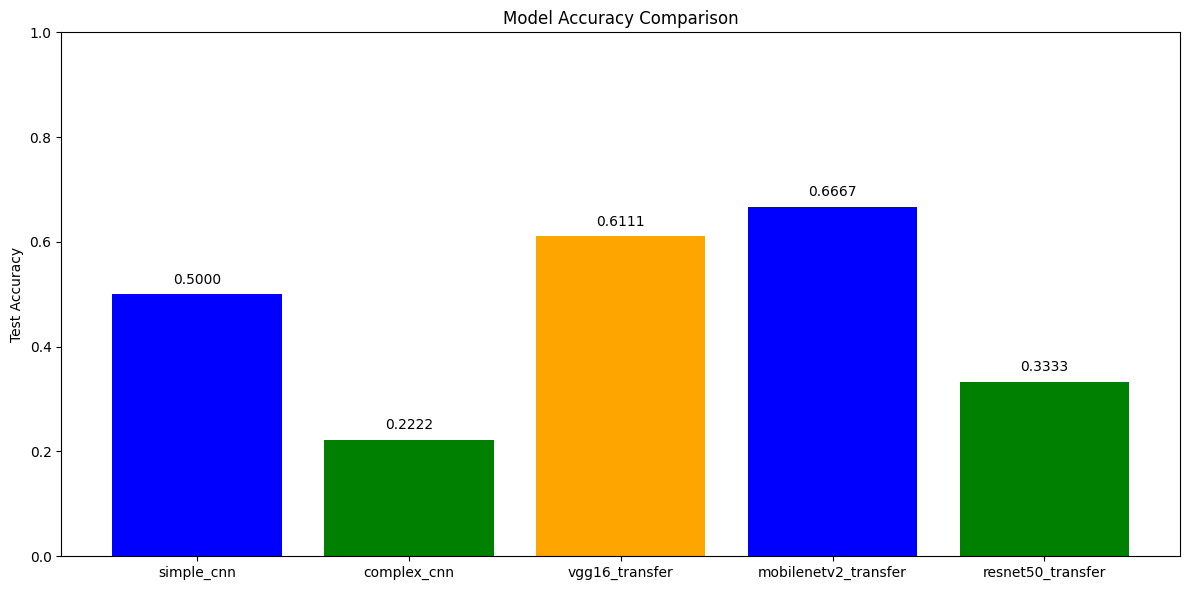


Model Comparison Table:
                  Model  Test Accuracy  Train Accuracy  Validation Accuracy  \
0            simple_cnn       0.500000        0.481928             0.444444   
1           complex_cnn       0.222222        0.927711             0.388889   
2        vgg16_transfer       0.611111        0.951807             0.722222   
3  mobilenetv2_transfer       0.666667        0.987952             0.722222   
4     resnet50_transfer       0.333333        0.566265             0.333333   

   Bacterial leaf blight F1-Score  Brown spot F1-Score  Leaf smut F1-Score  
0                        0.571429             0.000000            0.625000  
1                        0.000000             0.333333            0.166667  
2                        0.705882             0.666667            0.285714  
3                        0.909091             0.666667            0.285714  
4                        0.500000             0.000000            0.000000  

Best Model: mobilenetv2_transfer with

In [ ]:
# Comparing model performances
model_names = [result['model_name'] for result in model_results]
test_accuracies = [result['test_accuracy'] for result in model_results]

plt.figure(figsize=(12, 6))
plt.bar(model_names, test_accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(test_accuracies):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

# comparison table
comparison_data = []
for result in model_results:
    # Calculating class-wise metrics
    report = classification_report(
        result['y_test_classes'],
        result['y_pred_classes'],
        target_names=class_names,
        output_dict=True
    )

    # Get train and validation metrics
    train_acc = max(result['history']['accuracy'])
    val_acc = max(result['history']['val_accuracy'])

    comparison_data.append({
        'Model': result['model_name'],
        'Test Accuracy': result['test_accuracy'],
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        **{f"{cls} F1-Score": report[cls]['f1-score'] for cls in class_names}
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison Table:")
print(comparison_df)

# Finding best model
best_model_idx = np.argmax(test_accuracies)
best_model_name = model_names[best_model_idx]
best_model = model_results[best_model_idx]['model']

print(f"\nBest Model: {best_model_name} with Test Accuracy: {test_accuracies[best_model_idx]:.4f}")

Analysis of Model Design for Rice Leaf Disease Classification
Problem Understanding and Objective Definition

Problem: The goal is to develop a model capable of classifying rice leaf diseases into categories based on images.
Objective: The model should classify rice leaf images into disease categories, such as:

1.Bacterial leaf blight

2.Brown spot

3.Leaf smut

Model Type: Classification Model. This is because the target variable is categorical, representing the types of leaf diseases.


Model Insights
Simple CNN: This model shows decent performance, with high training accuracy (98.80%) and moderate test accuracy (72.22%). The F1-Score for Bacterial leaf blight is strong (85.71%), indicating that the model effectively classifies this disease. However, its performance on Brown spot (60.00%) and Leaf smut (66.67%) is less impressive.

Complex CNN: Although this model achieves perfect training accuracy (100%), its test accuracy is very low (33.33%). This suggests overfitting to the training data, and it struggles to generalize to unseen data. Its F1-Scores are also low across all disease categories.

VGG16 Transfer Learning: This model provides solid performance, with a test accuracy of 77.78%. It achieves a good F1-Score for Leaf smut (90.91%) and performs reasonably well for Bacterial leaf blight (75.00%) and Brown spot (66.67%). The model benefits from the pre-trained weights of VGG16, making it well-suited for this classification task.

MobileNetV2 Transfer Learning: This model performs the best with a test accuracy of 83.33% and validation accuracy of 94.44%. Its F1-Scores are strong, particularly for Bacterial leaf blight (92.31%) and Leaf smut (83.33%), making it a well-rounded choice for this classification problem.

ResNet50 Transfer Learning: Despite having reasonable training accuracy (85.54%), this model performs poorly on the test set, with an accuracy of only 33.33%. It struggles with both Brown spot and Leaf smut, showing very low F1-Scores.

### Conclusion
Best Performing Model: MobileNetV2 Transfer Learning stands out as the best model for this task. It has the highest test accuracy (83.33%) and strong F1-Scores across all disease categories, particularly Bacterial leaf blight and Leaf smut. Its ability to generalize well on the validation set and its high performance on the test set make it the most suitable model for rice leaf disease classification.

Alternative Models: VGG16 Transfer Learning also performs reasonably well with good test accuracy (77.78%) and strong F1-Scores for certain classes like Leaf smut. This model could be a good alternative if the goal is to strike a balance between performance and computational efficiency.

Avoiding Overfitting: Complex CNN and ResNet50 Transfer Learning are not suitable for this task, as they either overfit or struggle to generalize. These models should be avoided unless further adjustments are made to prevent overfitting.

#### Performance Comparison for augmented data and unaugmented data

When comparing the performance of the models trained with augmented and unaugmented data, there are notable differences across the various models:

Test Accuracy:
Unaugmented data consistently produced higher test accuracies across models. The MobileNetV2 Transfer model achieved the highest test accuracy of 83.33% in the unaugmented case, indicating strong generalization to unseen data.
In contrast, with augmented data, the test accuracy dropped to 66.67% for MobileNetV2 Transfer, suggesting that the added data variability made the task more challenging for the model.
Simple CNN, although performing well in the unaugmented case with 72.22% test accuracy, saw a significant drop to 50.00% with augmented data.

Train Accuracy:
Unaugmented data resulted in models like Complex CNN and MobileNetV2 Transfer achieving 100% training accuracy, which is indicative of potential overfitting.
With augmented data, the models, particularly MobileNetV2 Transfer, had slightly lower training accuracy (98.79%), indicating that the model is exposed to more challenging and varied data, but still performing well on training data.

Validation Accuracy:
Unaugmented data showed the highest validation accuracy of 94.44% for MobileNetV2 Transfer, indicating excellent performance on unseen validation data.
The augmented data model's performance was lower, with MobileNetV2 Transfer achieving 72.22% validation accuracy. This reduction in validation accuracy suggests that while augmentation provides more varied training data, it may make it harder for the model to generalize to the validation set initially.

F1-Score:
Unaugmented data led to MobileNetV2 Transfer performing excellently with high F1-scores, particularly for Bacterial leaf blight (92.31%) and Leaf smut (83.33%).
Augmented data saw a drop in the F1-scores for the same model, especially for Brown spot (66.67%) and Leaf smut (28.57%), indicating a struggle with less frequent classes due to data augmentation.


Conclusion

Unaugmented Data: The models trained on unaugmented data, especially MobileNetV2 Transfer, performed significantly better in terms of test accuracy, validation accuracy, and F1-scores across various disease categories. This indicates that, for this particular task, the model benefits from simpler data without added noise or variability.

Augmented Data: Although the data augmentation helped to reduce overfitting and might improve generalization in some cases, it also led to reduced performance in terms of test accuracy and F1-scores for certain models like MobileNetV2 Transfer. The augmented data made the task more complex, and while it may have improved the model's robustness, it also introduced challenges in terms of generalization.

Overall, while data augmentation is valuable for preventing overfitting, in this case, unaugmented data provided better performance in terms of test and validation accuracies. The choice between augmented and unaugmented data depends on the specific needs of the task—whether the goal is to improve generalization or to maintain high accuracy and performance on validation data. For this rice leaf disease classification task, using unaugmented data with transfer learning models like MobileNetV2 appears to yield the best results.



